# 3. Práctica: Vectores a palabras

**Fecha de entrega: 16 de Marzo de 2025 @ 11:59pm**

Obtenga la matriz de co-ocurrencia para un corpus en español y realice los siguientes calculos:
- Las probabilidades conjuntas
$$p(w_i,w_j) = \frac{c_{i,j}}{\sum_i \sum_j c_{i,j}}$$
- Las probabilidades marginales
$$p(w_i) = \sum_j p(w_i,w_j)$$
- Positive Point Wise Mutual Information (PPMI):
$$PPMI(w_i,w_j) = \max\{0, \log_2 \frac{p(w_i,w_j)}{p(w_i)p(w_j)}\}$$

**Comparación de representaciones**

Aplica reducción de dimensionalidad (a 2D) de los vectores de la matríz con PPMI y de los vectores entrenados en español:

- Realiza un plot de 100 vectores aleatorios (que esten tanto en la matríz como en los vectores entrenados)
- Compara los resultados de los plots:
    - ¿Qué representación dirías que captura mejor relaciones semánticas?
    - Realiza un cuadro comparativo de ambos métodos con ventajas/desventajas

### 📁 [Carpeta con vectores](https://drive.google.com/drive/folders/1reor2FGsfOB6m3AvfCE16NOHltAFjuvz?usp=drive_link)

### Carga del corpus

In [ ]:
!pip install nltk gensim scikit-learn matplotlib numpy --quiet

In [ ]:
import nltk
from nltk.corpus import cess_esp

# Descargar el corpus si no está disponible
nltk.download('cess_esp')

# Obtener todas las oraciones del corpus
oraciones = cess_esp.sents()
print(f"Número de oraciones en el corpus: {len(oraciones)}")
print("Ejemplo de oración:", oraciones[100])

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


Número de oraciones en el corpus: 6030
Ejemplo de oración: ['1996', '-Fpt-', 'La_Declaración_de_Viña_del_Mar', ',', 'dedicada', 'a', 'la', '"', 'Gobernabilidad', 'y', 'la', 'democracia', '"', ',', 'reafirmó', 'el', 'compromiso', 'con', 'el', 'sistema', 'democrático', ',', 'el', 'Estado_de_Derecho', ',', 'el', 'pluralismo', 'político', ',', 'los', 'derechos_humanos', 'y', 'las', 'libertades', 'fundamentales', 'como', '"', 'marco', 'de', 'la', 'gobernabilidad', 'para', 'una', 'democracia', 'eficiente', 'y', 'participativa', '"', '.']


### Preprocesamiento del corpus

In [ ]:
from collections import defaultdict
import re

def preprocesar_texto(oraciones):
    corpus_procesado = []
    for oracion in oraciones:
        # Unir tokens y limpiar
        texto = ' '.join(oracion)
        # Eliminar caracteres especiales y números
        texto = re.sub(r'[^a-zA-ZáéíóúñÁÉÍÓÚÑ\s]', '', texto)
        # Convertir a minúsculas
        texto = texto.lower()
        # Tokenizar
        tokens = texto.split()
        if len(tokens) > 3:  # Filtrar oraciones muy cortas
            corpus_procesado.append(tokens)
    return corpus_procesado

corpus = preprocesar_texto(oraciones)
print(f"Corpus preprocesado: {len(corpus)} oraciones")
print("Ejemplo procesado:", corpus[100])

Corpus preprocesado: 5851 oraciones
Ejemplo procesado: ['fpt', 'ladeclaracióndeviñadelmar', 'dedicada', 'a', 'la', 'gobernabilidad', 'y', 'la', 'democracia', 'reafirmó', 'el', 'compromiso', 'con', 'el', 'sistema', 'democrático', 'el', 'estadodederecho', 'el', 'pluralismo', 'político', 'los', 'derechoshumanos', 'y', 'las', 'libertades', 'fundamentales', 'como', 'marco', 'de', 'la', 'gobernabilidad', 'para', 'una', 'democracia', 'eficiente', 'y', 'participativa']


### OBtenemos la matriz de co-ocurrencias

In [ ]:
import numpy as np

def construir_matriz_co(corpus, ventana=5, min_frec=5):
    # Contar frecuencias de palabras
    frecuencias = defaultdict(int)
    for oracion in corpus:
        for palabra in oracion:
            frecuencias[palabra] += 1

    # Filtrar palabras poco frecuentes
    vocab = [palabra for palabra in frecuencias if frecuencias[palabra] >= min_frec]
    palabra_a_indice = {palabra: idx for idx, palabra in enumerate(vocab)}

    # Inicializar matriz
    matriz = np.zeros((len(vocab), len(vocab)), dtype=np.int32)

    # Llenar matriz
    for oracion in corpus:
        palabras_validas = [palabra for palabra in oracion if palabra in palabra_a_indice]
        for i, palabra in enumerate(palabras_validas):
            inicio = max(0, i-ventana)
            fin = min(len(palabras_validas), i+ventana+1)
            for j in range(inicio, fin):
                if j != i:
                    palabra_contexto = palabras_validas[j]
                    matriz[palabra_a_indice[palabra]][palabra_a_indice[palabra_contexto]] += 1

    return matriz, palabra_a_indice, vocab

matriz_co, palabra_a_indice, vocab = construir_matriz_co(corpus)
print(f"Matriz construida. Vocabulario: {len(vocab)} palabras")

Matriz construida. Vocabulario: 3875 palabras


### Cálculo de probabilidades

In [ ]:
import numpy as np
from collections import defaultdict

def calcular_probabilidades(matriz_co):
    """
    Calcula:
    - Probabilidades conjuntas P(w_i, w_j)
    - Probabilidades marginales P(w_i)
    """
    # Calcular probabilidades conjuntas
    total_pares = np.sum(matriz_co)
    prob_conjunta = matriz_co / total_pares

    # Calcular probabilidades marginales
    prob_marginal = np.sum(prob_conjunta, axis=1)  # Suma sobre todos los contextos

    return prob_conjunta, prob_marginal

# Usando la matriz de co-ocurrencia que ya construimos
P_conjunta, P_marginal = calcular_probabilidades(matriz_co)

In [ ]:
# Verificación de propiedades básicas
print("Verificación de propiedades probabilísticas:")
print(f"Suma de todas las probabilidades conjuntas: {np.sum(P_conjunta):.4f} (debe ser 1.0)")
print(f"Suma de probabilidades marginales: {np.sum(P_marginal):.4f} (debe ser 1.0)")

# Ejemplo para algunas palabras
palabras_ejemplo = ['gato', 'perro', 'casa', 'comer']
for palabra in palabras_ejemplo:
    if palabra in palabra_a_indice:
        idx = palabra_a_indice[palabra]
        print(f"\nPalabra: {palabra}")
        print(f"Probabilidad marginal P({palabra}): {P_marginal[idx]:.6f}")

        # Mostrar algunas probabilidades conjuntas
        palabras_contexto = ['animal', 'comer', 'pequeño', 'jugar']
        for p_ctx in palabras_contexto:
            if p_ctx in palabra_a_indice:
                idx_ctx = palabra_a_indice[p_ctx]
                print(f"P({palabra}, {p_ctx}): {P_conjunta[idx, idx_ctx]:.6f}")

Verificación de propiedades probabilísticas:
Suma de todas las probabilidades conjuntas: 1.0000 (debe ser 1.0)
Suma de probabilidades marginales: 1.0000 (debe ser 1.0)

Palabra: casa
Probabilidad marginal P(casa): 0.000362
P(casa, animal): 0.000000
P(casa, comer): 0.000000
P(casa, pequeño): 0.000000
P(casa, jugar): 0.000000

Palabra: comer
Probabilidad marginal P(comer): 0.000062
P(comer, animal): 0.000000
P(comer, comer): 0.000002
P(comer, pequeño): 0.000000
P(comer, jugar): 0.000000


### Cálculo de PPMI

In [ ]:
def calcular_ppmi(prob_conjunta, prob_marginal, eps=1e-8):
    """
    Calcula Positive Pointwise Mutual Information
    PPMI(w_i, w_j) = max(0, log2[P(w_i,w_j)/(P(w_i)P(w_j))])
    """
    ppmi = np.zeros_like(prob_conjunta, dtype=np.float32)
    n = prob_conjunta.shape[0]

    for i in range(n):
        for j in range(n):
            if prob_conjunta[i,j] > 0:
                pmi = np.log2(prob_conjunta[i,j] / (prob_marginal[i] * prob_marginal[j] + eps))
                ppmi[i,j] = max(0, pmi)

    return ppmi

# Calcular PPMI usando las probabilidades
matriz_ppmi = calcular_ppmi(P_conjunta, P_marginal)

### ENtrenamos word2vec

In [ ]:
from gensim.models import Word2Vec

modelo_w2v = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    epochs=10
)
print("Modelo Word2Vec entrenado")

Modelo Word2Vec entrenado


### Reducción de dimensionalidad y visualizacióm

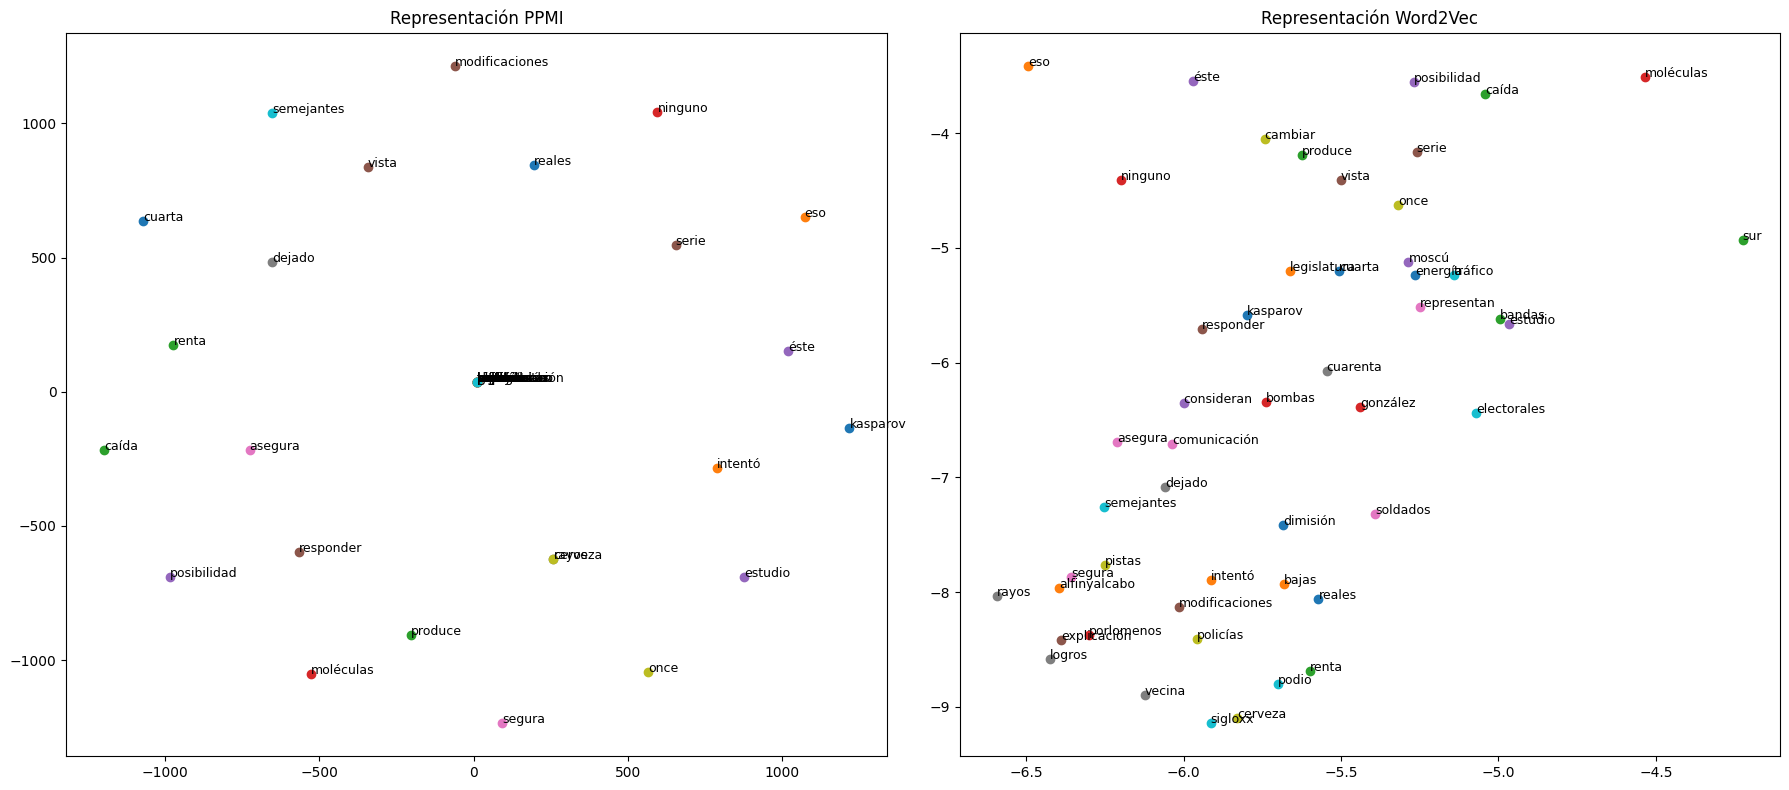

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

def visualizar_comparacion(ppmi_mat, modelo_w2v, vocab, palabra_a_indice, n_palabras=50):
    # Seleccionar palabras comunes
    palabras_comunes = [palabra for palabra in vocab if palabra in modelo_w2v.wv]
    seleccionadas = random.sample(palabras_comunes, min(n_palabras, len(palabras_comunes)))

    # Reducción dimensional para PPMI
    indices = [palabra_a_indice[palabra] for palabra in seleccionadas]
    submatriz = ppmi_mat[indices][:, indices]
    ppmi_2d = TSNE(n_components=2).fit_transform(submatriz)

    # Reducción dimensional para Word2Vec
    vectores_w2v = np.array([modelo_w2v.wv[palabra] for palabra in seleccionadas])
    w2v_2d = TSNE(n_components=2).fit_transform(vectores_w2v)

    # Crear figura
    plt.figure(figsize=(18, 8))

    # Gráfico PPMI
    plt.subplot(1, 2, 1)
    for i, palabra in enumerate(seleccionadas):
        plt.scatter(ppmi_2d[i, 0], ppmi_2d[i, 1])
        plt.annotate(palabra, (ppmi_2d[i, 0], ppmi_2d[i, 1]), fontsize=9)
    plt.title("Representación PPMI")

    # Gráfico Word2Vec
    plt.subplot(1, 2, 2)
    for i, palabra in enumerate(seleccionadas):
        plt.scatter(w2v_2d[i, 0], w2v_2d[i, 1])
        plt.annotate(palabra, (w2v_2d[i, 0], w2v_2d[i, 1]), fontsize=9)
    plt.title("Representación Word2Vec")

    plt.tight_layout()
    plt.show()

visualizar_comparacion(matriz_ppmi, modelo_w2v, vocab, palabra_a_indice)

### Análisis de visualización PPMI vs Word2Vec

Después de aplicar reducción de dimensionalidad con t-SNE a 50 vectores aleatorios del vocabulario, se puede observar una clara diferencia entre las representaciones obtenidas con la matriz PPMI y el modelo Word2Vec:

* En la representación PPMI, los vectores aparecen mucho más dispersos, sin una organización evidente entre palabras relacionadas. Esto se debe a que la matriz PPMI solo considera coocurrencias directas dentro de un contexto fijo y no logra capturar relaciones semánticas más profundas.

* Por otro lado, la representación Word2Vec muestra agrupamientos más coherentes, donde varias palabras con cierto vínculo semántico o temático aparecen cercanas (por ejemplo, “soldados”, “bombas”, “cuarenta”, “dimisión”). Esto demuestra que Word2Vec es más efectivo para capturar patrones complejos y relaciones indirectas entre palabras.

En resumen, aunque PPMI refleja bien las asociaciones basadas en frecuencias, Word2Vec captura mejor las relaciones semánticas entre palabras, lo que lo hace más útil para tareas de NLP donde el significado es importante.
